<a href="https://colab.research.google.com/github/nunocesarsa/GoogleColab_public/blob/master/Bayes_Optimization_RTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#hyperspectral data package
!pip install pysptools

#prosail...
!pip install prosail

#statistical parameter optimization tools package
#!pip install spotpy
!pip install GPyOpt

!pip install bayesian_optimization

#latin hypercube module
!pip install lhsmdu

     |████████████████████████████████| 8.1MB 4.0MB/s 
  Created wheel for pysptools: filename=pysptools-0.15.0-cp36-none-any.whl size=8133747 sha256=2322bb4c4e7e146914abfe13d1c7af788c8767d43e3ec699e3f3bf3a1f23aad3
  Stored in directory: /root/.cache/pip/wheels/bf/60/be/a6719d91bfa59135201feb034c7069e4146aa576fc0dc9e624
Successfully built pysptools
     |████████████████████████████████| 153kB 4.9MB/s 
     |████████████████████████████████| 61kB 2.4MB/s 
     |████████████████████████████████| 1.0MB 13.6MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.5-cp36-none-any.whl size=83027 sha256=b030c7b0f6ed596c154369220ea94af4fc68e6738f5fc95d0540c795bb145b6e
  Stored in directory: /root/.cache/pip/wheels/33/1d/87/dc02440831ba986b1547dd11a7dcd44e893b0527083066d869
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2634001 sha256=6d6a5e83aa69b17318277907765f9c7f0577e675a7a50f1edb0a52c8b98f38f1
  Stored in dir

In [0]:
try:
    # Check if notebook is running in Google Colab
    import google.colab
    # Get additional files from Github
    !wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/master/bayesian_optimization_util.py
    # Install additional dependencies
    !pip install scikit-optimize==0.5.2
    !pip install GPy==1.9.8
    !pip install GPyOpt==1.2.1
    !pip install xgboost==0.90
except:
    pass


--2019-12-08 10:07:54--  https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/master/bayesian_optimization_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1536 (1.5K) [text/plain]
Saving to: ‘bayesian_optimization_util.py’

bayesian_optimizati 100%[===================>]   1.50K  --.-KB/s    in 0s      

2019-12-08 10:07:54 (302 MB/s) - ‘bayesian_optimization_util.py’ saved [1536/1536]

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 993kB 5.1MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp36-cp36m-linux_x86_64.whl size=2626145 sha256=0d3d3d1a9b9c34f1f31f6cd2446c2b6bcffc149b6a2643db1540726f8d010de6
  Stored in directory: /root/.cache/pip/wheels/96/ee/cd/1c4dd7df63246b1e8de58af6d4457b7aed1350

In [0]:
#loading the packages

#these packages are for operations on hyperspectral data
import pysptools as sptool #https://pysptools.sourceforge.io/
from pysptools import distance

#this is the core RTM model i am using, prosail
import prosail
#import spotpy

#standard minimization package
from scipy.optimize import minimize

#importing machine learning stuff 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

#and also Bayes optimization packages 
from bayesian_optimization_util import plot_approximation, plot_acquisition

In [0]:
## creating a objective function, inputs are 2 spectras outputs from prosail

def spectra_diff(rho_in,rho_target):
  #Spectral angle mapper (cossine sum, or something of the like)
  out_val_sam =   sptool.distance.SAM(rho_in,rho_target)
  #chebyshev distance
  out_val_cheb = sptool.distance.chebyshev(rho_in,rho_target)
  #normalized cross correlation
  out_val_normcross = sptool.distance.chebyshev(rho_in,rho_target)
  #spectral information divergence
  out_val_SID = sptool.distance.SID(rho_in,rho_target)

  out_fin = out_val_sam  + out_val_cheb + out_val_normcross + out_val_SID

  return out_fin

#shared inputs
lidfa = -0.35 #leaf angle distribution parameter a and b
lidfb=-0.15
hspot=0.01 #hotspot parameters
tts=30. #observation and solar position parameters
tto=10. 
psi=0.


#Testing the function to compare spectraa
n1=1.5
cab1=80.
car1=20.
cbrown1=0.01
cw1=0.0
cm1=0.009
lai1 =3.

n2=1.5
cab2=80.
car2=20.
cbrown2=0.01
cw2=0.0
cm2=0.009
lai2 =6.

#standar prosail call
prosail.run_prosail(n1,
                    cab1,
                    car1,
                    cbrown1,
                    cw1,
                    cm1,
                    lai1,
                    lidfa,hspot,tts,tto,psi,
                    typelidf=1, #lidfb=-0.15,
                    factor='SDR', rsoil=1., psoil=1.)

rho_in = prosail.run_prosail(n1,
                    cab1,
                    car1,
                    cbrown1,
                    cw1,
                    cm1,
                    lai1,
                    lidfa,hspot,tts,tto,psi,
                    typelidf=1, #lidfb=-0.15,
                    factor='SDR', rsoil=1., psoil=1.)

rho_test = prosail.run_prosail(n2,
                               cab2,
                               car2,
                               cbrown2,
                               cw2,
                               cm2,
                               lai2,
                               lidfa,hspot,tts,tto,psi,
                               typelidf=1, #lidfb=-0.15,
                               factor='SDR', rsoil=1., psoil=1.)


print(spectra_diff(rho_in,rho_test))
print(spectra_diff(rho_in,rho_in))
print(spectra_diff(rho_test,rho_test))

0.1579455502297151
1.4901161193847656e-08
0.0


In [0]:
#creating a cost function for my problem

#the input is the set of parameters i am targetting to get to and the specral matrix to be thrown into the custom spectra difference function
#probably stupid to have divided this into two functions
def cost_fun_standard(x,rho):
  #shared inputs
  lidfa = -0.35 #leaf angle distribution parameter a and b
  lidfb=-0.15
  hspot=0.01 #hotspot parameters
  tts=30. #observation and solar position parameters
  tto=10. 
  psi=0.
  n1,cab1,car1,cbrown1,cw1,cm1,lai1  = x #its easy to change here to add more target parameters! cool 
  rho_prosail = prosail.run_prosail(n1,
                                    cab1,
                                    car1,
                                    cbrown1,
                                    cw1,
                                    cm1,
                                    lai1,
                                    lidfa,hspot,tts,tto,psi,
                                    typelidf=1, #lidfb=-0.15,
                                    factor='SDR', rsoil=1., psoil=1.)
  
  return(spectra_diff(rho_prosail,rho))

#testing the function
x=n2,cab2,car2,cbrown2,cw2,cm2,lai2

print(cost_fun_standard(x,rho_in))



0.1579455502297151


In [0]:
#lets try a standard minimization 
x=n1,cab1,car1,cbrown1,cw1,cm1,lai1
minimize(cost_fun_standard,x,args=rho_test,
               method='L-BFGS-B')


      fun: 0.1309790847325713
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.02766462e-01, -8.50708393e-05, -2.25569563e-05,  6.68721245e-02,
       -6.99629589e+00,  2.95532237e+00, -1.22395866e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 664
      nit: 7
   status: 0
  success: True
        x: array([1.49999990e+00, 8.00000000e+01, 2.00000000e+01, 9.99744566e-03,
       2.86615642e-04, 9.10567265e-03, 3.00000076e+00])

In [0]:
#adapting form the codes here in: 
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [0]:
#this creates the gpr object which is a GPR ML model with the given characteristics
gpr = GaussianProcessRegressor(n_restarts_optimizer=20,
                                        #normalize_y=True,
                                        random_state=1)

#we create a custom function to call prosail based only on my interest parameters
def custom_prosail(n,cab,car,cbrown,cw,cm,lai):
  #shared inputs
  lidfa = -0.35 #leaf angle distribution parameter a and b
  lidfb=-0.15
  hspot=0.01 #hotspot parameters
  tts=30. #observation and solar position parameters
  tto=10. 
  psi=0.
  rho_out = prosail.run_prosail(n,
                                 cab,
                                 car,
                                 cbrown,
                                 cw,
                                 cm,
                                 lai,
                                 lidfa,hspot,tts,tto,psi,
                                 typelidf=1, #lidfb=-0.15,
                                 factor='SDR', rsoil=1., psoil=1.)
  return(rho_out)



#first we set which trait values i want to predict
n1=1.5
cab1=80.
car1=20.
cbrown1=0.01
cw1=0.0
cm1=0.009
lai1 =3.

X_sample = n1,cab1,car1,cbrown1,cw1,cm1,lai1
#then we push the values for the sample
Y_sample = custom_prosail(*X_sample)




            n        cab        car    cbrown        cw        cm       lai
0    1.126658  44.362176  25.151085  6.629152  0.006263  0.006456  2.816050
1    1.905452  56.967754  32.171914  9.002161  0.002372  0.008193  4.726169
2    1.740852  79.030521  44.460037  9.049798  0.004291  0.002191  9.765008
3    1.718563  57.456529  32.444143  0.695435  0.006077  0.005632  0.313264
4    1.596306  28.738046  16.449038  5.033376  0.002218  0.006937  1.236455
..        ...        ...        ...       ...       ...       ...       ...
995  1.634963  22.625668  13.044676  2.032618  0.005186  0.004987  0.585619
996  1.981051  76.247032  42.909739  8.971693  0.005251  0.007174  9.464488
997  1.917712  32.907898  18.771488  2.027289  0.002641  0.006963  2.801280
998  1.375118  79.394019  44.662491  0.724488  0.001029  0.006623  4.593259
999  1.855524  41.675130  23.654503  3.093175  0.003546  0.006749  9.786241

[1000 rows x 7 columns]


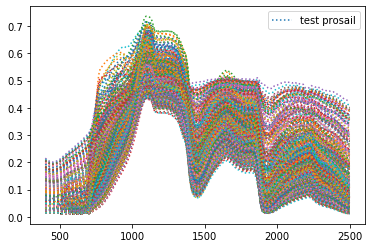

In [0]:
import pandas as pd
import numpy as np
import numpy
#latin hypercube stuff
import lhsmdu
#ploting options
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#b = np.array([[-0.9], [1.1]])
#X_sample = n1,cab1,car1,cbrown1,cw1,cm1,lai1
#X_sample


#number of samples
samples_n = 1000

#lets generate 1000 samples of spectra/traits which then i can use later in a ML approach or optimization
trait_7d_lhs = lhsmdu.createRandomStandardUniformMatrix(7,samples_n) #perhaps this one is not as good but its definitly faster
#generates a latin hypercube space from range [0, 1] 

#max values for generating the spectra
#to avoid negatives, i will add a minimum value to each in the end
max_n=1 #this value should go from 1 to 2, so i make it change from 0 to 1 here and then add 1 later
max_cab=79. #add 1
max_car=44. #add 1
max_cbrown= 9.99 #add 0.01
max_cw=0.008 #add 0.001 
max_cm=0.008 #0.001
max_lai = 9.9 #add 0.1

pd_tr_traits = pd.DataFrame.transpose(pd.DataFrame(trait_7d_lhs))
pd_tr_traits.columns = ["n","cab","car","cbrown","cw","cm","lai"]

#this addition is to avoid extreme values that can perhaps cause prosail failure
pd_tr_traits["n"]=pd_tr_traits["n"]*max_n+1
#pd_tr_traits["car"]=pd_tr_traits["car"]*max_car+1 
pd_tr_traits["car"]=pd_tr_traits["cab"]*max_car+1 #changed here to cab to ensure that it is 100% autocorrelated 
pd_tr_traits["cab"]=pd_tr_traits["cab"]*max_cab+1
pd_tr_traits["cbrown"]=pd_tr_traits["cbrown"]*max_cbrown+ 0.01
pd_tr_traits["cw"]=pd_tr_traits["cw"]*max_cw+.001
pd_tr_traits["cm"]=pd_tr_traits["cm"]*max_cm+.001
pd_tr_traits["lai"]=pd_tr_traits["lai"]*max_lai+.1

print(pd_tr_traits)

#lets generate a spectra table
#aux for x axis plotting help
x = np.arange(400,2501)
x[-1]

k = 1
#probably would be smart to create a function for this with optional plotting
#for i in range(10):
for i in range(len(pd_tr_traits)):
    #print(i)

    n_t = pd_tr_traits["n"][i]
    cab_t = pd_tr_traits["cab"][i]
    car_t = pd_tr_traits["car"][i]
    cbrown_t = pd_tr_traits["cbrown"][i]
    cw_t = pd_tr_traits["cw"][i]
    cm_t = pd_tr_traits["cm"][i]
    lai_t = pd_tr_traits["lai"][i]


    if k == 1:
      tr_rho_s = custom_prosail(n_t,cab_t,car_t,
                                  cbrown_t,cw_t,cm_t,
                                  lai_t)
      plt.plot ( x, tr_rho_s, ':', label="test prosail")
      plt.legend(loc='best')
      
    if k > 1:
      tr_rho_t = custom_prosail(n_t,cab_t,car_t,
                                  cbrown_t,cw_t,cm_t,
                                  lai_t)
      
      tr_rho_s = np.vstack((tr_rho_s,tr_rho_t))
      plt.plot ( x, tr_rho_t, ':')

    
    k = k+1

plt.show()

#custom_prosail?

In [0]:
#quick training of a GPR model
prosail_7p_grp = GaussianProcessRegressor(n_restarts_optimizer=20,
                                        #normalize_y=True,
                                        random_state=1)

prosail_7p_grp.fit(tr_rho_s, pd_tr_traits)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=20, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=1)

            n        cab        car    cbrown        cw        cm       lai
0    1.538159  56.930854  32.151362  1.100402  0.004943  0.007375  2.310689
1    1.353336  24.711060  14.206160  0.500706  0.005719  0.008109  7.680347
2    1.478462  58.223235  32.871169  1.038452  0.004491  0.007858  6.992982
3    1.541172  76.699596  43.161801  1.370405  0.004568  0.007380  0.908252
4    1.253070  42.654210  24.199813  7.132262  0.003375  0.008303  2.789100
..        ...        ...        ...       ...       ...       ...       ...
245  1.102090  45.520276  25.796103  7.716000  0.002395  0.002284  9.790810
246  1.917231  12.229065   7.254163  0.856519  0.006224  0.004571  5.974277
247  1.165325  22.092775  12.747875  3.540511  0.002305  0.003458  7.950441
248  1.421616  42.888587  24.330352  9.331515  0.008933  0.006967  0.936073
249  1.937046  71.786475  40.425379  9.172115  0.007806  0.005412  2.600410

[250 rows x 7 columns]


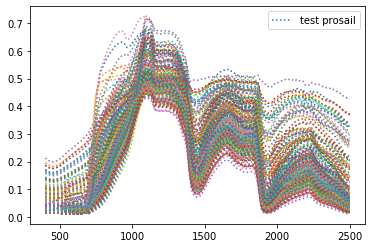

In [0]:
#creating a test dataset for the ML

#number of samples
vl_samples_n = 250

#lets generate 1000 samples of spectra/traits which then i can use later in a ML approach or optimization
vl_trait_7d_lhs = lhsmdu.createRandomStandardUniformMatrix(7,vl_samples_n) #perhaps this one is not as good but its definitly faster
#generates a latin hypercube space from range [0, 1] 

pd_vl_traits = pd.DataFrame.transpose(pd.DataFrame(vl_trait_7d_lhs))
pd_vl_traits.columns = ["n","cab","car","cbrown","cw","cm","lai"]

#this addition is to avoid extreme values that can perhaps cause prosail failure
pd_vl_traits["n"]=pd_vl_traits["n"]*max_n+1
#pd_vl_traits["car"]=pd_vl_traits["car"]*max_car+1
pd_vl_traits["car"]=pd_vl_traits["cab"]*max_car+1 #again forcing 100% correlation between car and cab
pd_vl_traits["cab"]=pd_vl_traits["cab"]*max_cab+1
pd_vl_traits["cbrown"]=pd_vl_traits["cbrown"]*max_cbrown+ 0.01
pd_vl_traits["cw"]=pd_vl_traits["cw"]*max_cw+.001
pd_vl_traits["cm"]=pd_vl_traits["cm"]*max_cm+.001
pd_vl_traits["lai"]=pd_vl_traits["lai"]*max_lai+.1

print(pd_vl_traits)

#lets generate a spectra table
#aux for x axis plotting help
x = np.arange(400,2501)
x[-1]

k = 1
#probably would be smart to create a function for this with optional plotting
#for i in range(10):
for i in range(len(pd_vl_traits)):
    #print(i)

    n_t = pd_vl_traits["n"][i]
    cab_t = pd_vl_traits["cab"][i]
    car_t = pd_vl_traits["car"][i]
    cbrown_t = pd_vl_traits["cbrown"][i]
    cw_t = pd_vl_traits["cw"][i]
    cm_t = pd_vl_traits["cm"][i]
    lai_t = pd_vl_traits["lai"][i]


    if k == 1:
      vl_rho_s = custom_prosail(n_t,cab_t,car_t,
                                  cbrown_t,cw_t,cm_t,
                                  lai_t)
      plt.plot ( x, vl_rho_s, ':', label="test prosail")
      plt.legend(loc='best')
      
    if k > 1:
      vl_rho_t = custom_prosail(n_t,cab_t,car_t,
                                  cbrown_t,cw_t,cm_t,
                                  lai_t)
      
      vl_rho_s = np.vstack((vl_rho_s,vl_rho_t))
      plt.plot ( x, vl_rho_t, ':')

    
    k = k+1

plt.show()


In [0]:
prosail_7p_pred_gpr = prosail_7p_grp.predict(vl_rho_s)

pd_pred = pd.DataFrame(prosail_7p_pred_gpr)
print(pd_pred)

            0          1          2         3         4         5         6
0    1.610928  70.862661  39.903082  1.058844  0.004827  0.007541  2.556859
1    1.317307  22.137530  12.774071  0.424543  0.006022  0.007884  6.513079
2    1.477637  54.928464  31.036445  1.047757  0.004550  0.007905  7.642120
3    1.497653  80.538077  45.295137  1.494222  0.004594  0.007061  0.889338
4    1.243858  43.063685  24.426840  7.145102  0.003368  0.008322  2.870196
..        ...        ...        ...       ...       ...       ...       ...
245  1.154600  43.376651  24.598938  7.834610  0.002468  0.002291  9.570103
246  1.669734  17.157033  10.008745  0.905814  0.006264  0.004295  9.318080
247  1.164518  22.580400  13.020914  3.566132  0.002292  0.003476  7.901434
248  1.419836  34.614489  19.723692  9.400228  0.008840  0.007042  0.940684
249  1.919007  61.037157  34.439063  9.122348  0.007787  0.005363  2.635657

[250 rows x 7 columns]


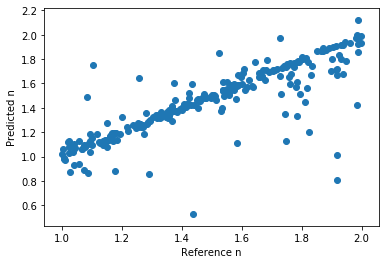

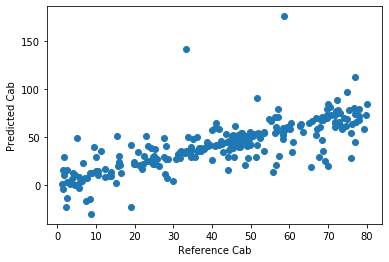

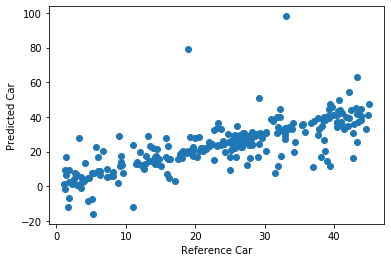

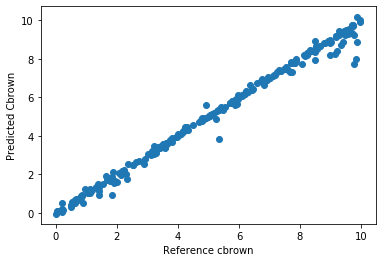

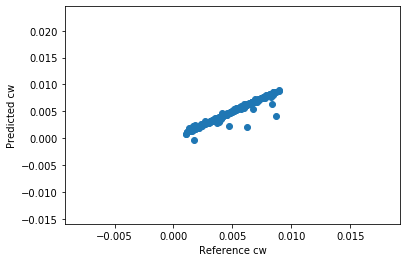

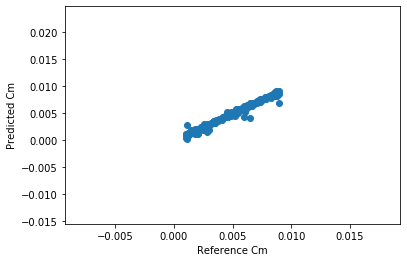

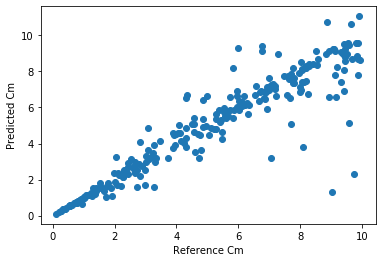

In [0]:


pd_pred.columns = ["n","cab","car","cbrown","cw","cm","lai"]

plt.scatter(pd_vl_traits["n"],pd_pred["n"])
plt.xlabel("Reference n")
plt.ylabel("Predicted n")
plt.show()

plt.scatter(pd_vl_traits["cab"],pd_pred["cab"])
plt.xlabel("Reference Cab")
plt.ylabel("Predicted Cab")
plt.show()

plt.scatter(pd_vl_traits["car"],pd_pred["car"])
plt.xlabel("Reference Car")
plt.ylabel("Predicted Car")
plt.show()

plt.scatter(pd_vl_traits["cbrown"],pd_pred["cbrown"])
plt.xlabel("Reference cbrown")
plt.ylabel("Predicted Cbrown")
plt.show()

plt.scatter(pd_vl_traits["cw"],pd_pred["cw"])
plt.xlabel("Reference cw")
plt.ylabel("Predicted cw")
plt.show()

plt.scatter(pd_vl_traits["cm"],pd_pred["cm"])
plt.xlabel("Reference Cm")
plt.ylabel("Predicted Cm")
plt.show()


plt.scatter(pd_vl_traits["lai"],pd_pred["lai"])
plt.xlabel("Reference LAI")
plt.ylabel("Predicted LAI")
plt.show()
